RQ2: To what extent do non-trivial open-source repositories that implement both GUI and performance end-to-end tests differ from those that implement only GUI end-to-end tests or only performance end-to-end tests, with respect to project activity metrics such as the number of commits, contributors, issues, and pull requests?

### Imports

In [93]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

### Load CSVs

In [94]:
df_repository_general = pd.read_csv('E2EGit\\repository.csv')
df_repository_general = df_repository_general.rename(columns={'name': 'repository_name'})
df_repository_general = df_repository_general[['repository_name', 'commits','contributors', 'total_issues', 'total_pull_requests']]

df_filtered = df_repository_general[
    (df_repository_general['commits'] >= 2000) &
    (df_repository_general['contributors'] >= 10) &
    (df_repository_general['total_issues'] >= 100) &
    (df_repository_general['total_pull_requests'] >= 50)
].reset_index(drop=True)

df_filtered.head(10)

C:\Users\lungu\AppData\Local\Temp\ipykernel_23280\3312153386.py:1: DtypeWarning: Columns (6,7,8,9,14,15,16,24,25,26,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df_repository_general = pd.read_csv('E2EGit\\repository.csv')


,repository_name,commits,contributors,total_issues,total_pull_requests
0,sparklemotion/nokogiri,7305.0,224.0,1953.0,1095.0
1,junit-team/junit4,2509.0,146.0,829.0,903.0
2,unclebob/fitnesse,6054.0,114.0,763.0,727.0
3,connectbot/connectbot,2207.0,57.0,527.0,855.0
4,bndtools/bndtools,3563.0,28.0,1291.0,643.0
5,caelum/vraptor,3448.0,60.0,455.0,209.0
6,maxcom/lorsource,8917.0,75.0,301.0,758.0
7,rzwitserloot/lombok,3243.0,106.0,2458.0,354.0
8,voldemort/voldemort,4263.0,57.0,136.0,371.0
9,jdbi/jdbi,5615.0,131.0,1051.0,1555.0


Load non_trivial_repository CSV

In [95]:
df_repository_non_trivial = pd.read_csv('E2EGit\\non_trivial_repository.csv')

df_repository_non_trivial = df_repository_non_trivial.rename(columns={'name': 'repository_name'})

df_repository_non_trivial = df_repository_non_trivial[['repository_name']]

Merge general info with non trivial repos

In [96]:
df_repository = pd.merge(df_filtered, df_repository_non_trivial, left_on='repository_name', right_on='repository_name', how='inner')

print(len(df_repository))

print(df_repository)

10727
                         repository_name  commits  contributors  total_issues   
0                 sparklemotion/nokogiri   7305.0         224.0        1953.0  \
1                      junit-team/junit4   2509.0         146.0         829.0   
2                      unclebob/fitnesse   6054.0         114.0         763.0   
3                  connectbot/connectbot   2207.0          57.0         527.0   
4                      bndtools/bndtools   3563.0          28.0        1291.0   
...                                  ...      ...           ...           ...   
10722             jeff-regier/Celeste.jl   2316.0          11.0         313.0   
10723                 denizyuret/Knet.jl   3086.0          33.0         495.0   
10724                numenta/htmresearch   5346.0          27.0         115.0   
10725          huaweicloud/ModelArts-Lab   2541.0         277.0         171.0   
10726  girlscript/winter-of-contributing  10156.0         416.0        4098.0   

       total_pull_req

Clean up the data

In [97]:
numeric_cols = ['commits', 'contributors', 'total_issues', 'total_pull_requests']

for col in numeric_cols:
    df_repository[col] = pd.to_numeric(df_repository[col], errors='coerce')

# drop NaNs
df_repository = df_repository.dropna(subset=numeric_cols)

print(df_repository)
print(len(df_repository))

                         repository_name  commits  contributors  total_issues   
0                 sparklemotion/nokogiri   7305.0         224.0        1953.0  \
1                      junit-team/junit4   2509.0         146.0         829.0   
2                      unclebob/fitnesse   6054.0         114.0         763.0   
3                  connectbot/connectbot   2207.0          57.0         527.0   
4                      bndtools/bndtools   3563.0          28.0        1291.0   
...                                  ...      ...           ...           ...   
10722             jeff-regier/Celeste.jl   2316.0          11.0         313.0   
10723                 denizyuret/Knet.jl   3086.0          33.0         495.0   
10724                numenta/htmresearch   5346.0          27.0         115.0   
10725          huaweicloud/ModelArts-Lab   2541.0         277.0         171.0   
10726  girlscript/winter-of-contributing  10156.0         416.0        4098.0   

       total_pull_requests 

Load GUI details CSV

In [98]:
df_gui_repo_details = pd.read_csv('E2EGit\gui_testing_repo_details.csv')[['repository_name']].drop_duplicates()

print(df_gui_repo_details)
print(len(df_gui_repo_details))

                        repository_name
0                       quantumlib/cirq
1                           wandb/weave
2    insightsoftwareconsortium/itk-wasm
3              codyogden/killedbygoogle
4                 mattermost/mattermost
..                                  ...
467               wp-graphql/wp-graphql
468               reduxjs/redux-toolkit
469           facebook/create-react-app
470                            zkoss/zk
471                   grafana/pyroscope

[472 rows x 1 columns]
472


Load performance details CSV

In [115]:
df_performance_test_details = pd.read_csv(r'E2EGit\performance_testing_test_details.csv')[['repository_name']].drop_duplicates()

print(df_performance_test_details)
print(len(df_performance_test_details))

                                    repository_name
0                                     apache/roller
1                          nysenate/openlegislation
6                             eclipse/jetty.project
8                                        apereo/cas
16                            mapfish/mapfish-print
..                                              ...
389                                        wso2/apk
390                                apache/eventmesh
391  ballerina-platform/ballerina-performance-cloud
403                        HumanSignal/label-studio
408                             jetty/jetty.project

[84 rows x 1 columns]
84


Merge performance with GUI testing to get repositories that implement both

In [100]:
df_both_tests = pd.merge(df_performance_test_details, df_gui_repo_details, on='repository_name', how='inner')

print(df_both_tests)
print(len(df_both_tests))

               repository_name
0                apache/roller
1            apache/tapestry-5
2          zkoss/zkspreadsheet
3             eugenp/tutorials
4        gluufederation/oxauth
5              wso2/product-is
6                eclipse/vorto
7            wso2/product-iots
8   ant-media/ant-media-server
9            kubeshop/testkube
10         janssenproject/jans
11       quadratichq/quadratic
12    HumanSignal/label-studio
13


Get reposorties that implement GUI only

In [101]:
df_gui_only = pd.merge(df_gui_repo_details, df_performance_test_details, on='repository_name', how='left', indicator=True)
df_gui_only = df_gui_only[df_gui_only['_merge'] == 'left_only'][['repository_name']]

print(df_gui_only)
print(len(df_gui_only))

                        repository_name
0                       quantumlib/cirq
1                           wandb/weave
2    insightsoftwareconsortium/itk-wasm
3              codyogden/killedbygoogle
4                 mattermost/mattermost
..                                  ...
467               wp-graphql/wp-graphql
468               reduxjs/redux-toolkit
469           facebook/create-react-app
470                            zkoss/zk
471                   grafana/pyroscope

[459 rows x 1 columns]
459


Get reposorties that implement Performance only

In [102]:
df_perf_only = pd.merge(df_performance_test_details, df_gui_repo_details, on='repository_name', how='left', indicator=True)
df_perf_only = df_perf_only[df_perf_only['_merge'] == 'left_only'][['repository_name']]

print(df_perf_only)
print(len(df_perf_only))

                                   repository_name
1                         nysenate/openlegislation
2                            eclipse/jetty.project
3                                       apereo/cas
4                            mapfish/mapfish-print
5                                 ippontech/tatami
..                                             ...
78                      spring-attic/spring-native
79                                        wso2/apk
80                                apache/eventmesh
81  ballerina-platform/ballerina-performance-cloud
83                             jetty/jetty.project

[71 rows x 1 columns]
71


Merge both Dataframe with the Dataframe that contains project activity

In [103]:
repo_both_with_repository_details = pd.merge(df_both_tests, df_repository, on='repository_name', how='inner')

repo_both_with_repository_details.head(10)

,repository_name,commits,contributors,total_issues,total_pull_requests
0,eugenp/tutorials,15392.0,321.0,733.0,15512.0
1,gluufederation/oxauth,5690.0,50.0,1296.0,575.0
2,wso2/product-is,12891.0,210.0,13272.0,6709.0
3,eclipse/vorto,3031.0,42.0,1341.0,1462.0
4,wso2/product-iots,2451.0,51.0,1353.0,593.0
5,ant-media/ant-media-server,7425.0,34.0,4779.0,1034.0
6,kubeshop/testkube,3133.0,74.0,1902.0,2307.0
7,janssenproject/jans,33804.0,86.0,3327.0,4707.0
8,quadratichq/quadratic,5055.0,20.0,442.0,805.0
9,HumanSignal/label-studio,3243.0,109.0,1978.0,3523.0


Not merged repositories (exist in GUI or Performance but not in both) with repository details

In [104]:
repo_gui_only_with_repository_details = pd.merge(df_gui_only, df_repository, on='repository_name', how='inner')
repo_perf_only_with_repository_details = pd.merge(df_perf_only, df_repository, on='repository_name', how='inner')

print(len(repo_gui_only_with_repository_details))
print(len(repo_perf_only_with_repository_details))


387
51


In [105]:
for name, df in [('GUI', df_gui_repo_details), ('Perf', df_performance_test_details),
                 ('Both', df_both_tests), ('GUI-only', df_gui_only), ('Perf-only', df_perf_only)]:
    print(name, len(df), df['repository_name'].nunique())
    assert len(df) == df['repository_name'].nunique()


GUI 472 472
Perf 84 84
Both 13 13
GUI-only 459 459
Perf-only 71 71


Add a column to each DataFrame to identify their type

In [106]:
repo_both_with_repository_details['test_type'] = 'Both'
repo_gui_only_with_repository_details['test_type'] = 'GUI'
repo_perf_only_with_repository_details['test_type'] = 'Performance'

Get the final DataFrame

In [107]:
df_all = pd.concat([repo_both_with_repository_details, repo_gui_only_with_repository_details, repo_perf_only_with_repository_details], ignore_index=True)

print(len(df_all))

448


### Plots

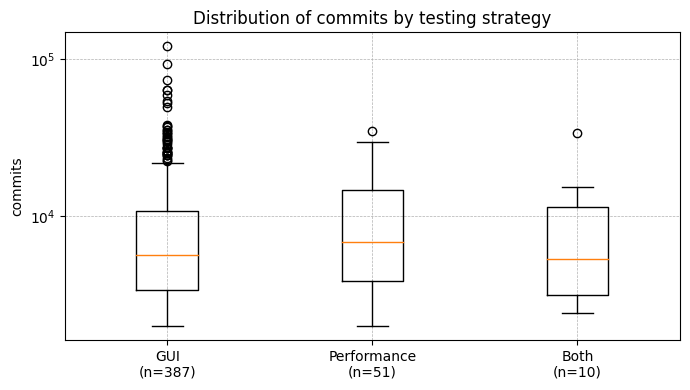

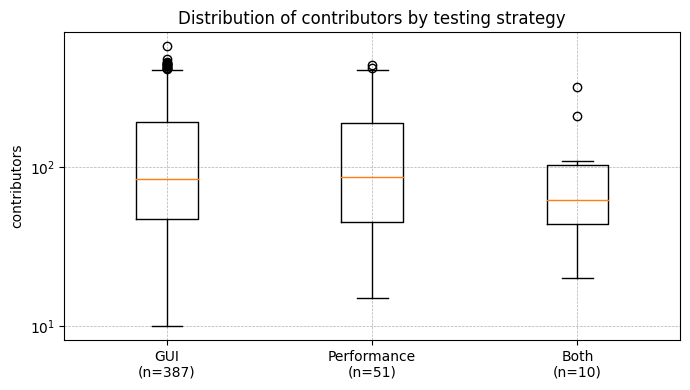

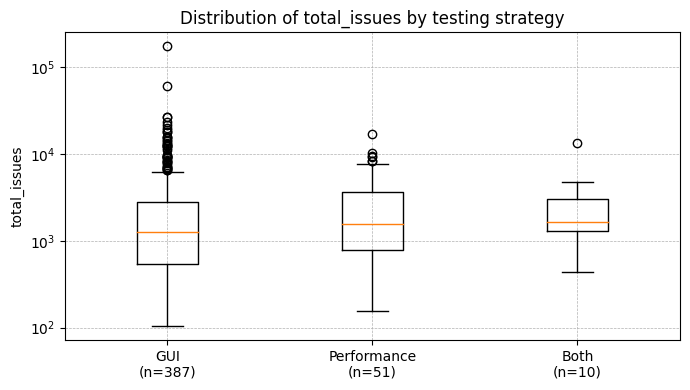

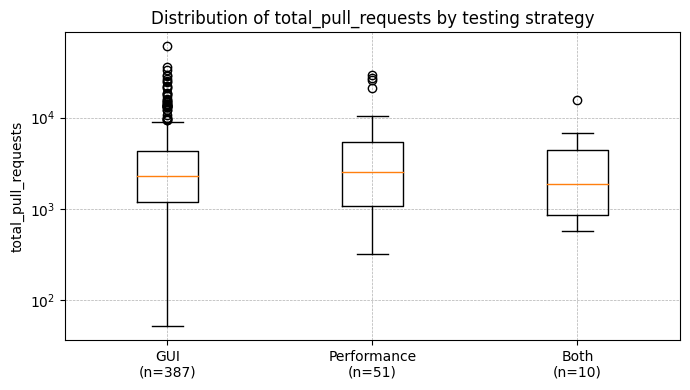

In [108]:
group_col = "test_type"
metrics = ["commits", "contributors", "total_issues", "total_pull_requests"]

plot_df = df_all[[group_col] + metrics].copy()
for m in metrics:
    plot_df[m] = pd.to_numeric(plot_df[m], errors="coerce")
plot_df = plot_df.dropna(subset=metrics)
plot_df = plot_df[(plot_df[metrics] >= 0).all(axis=1)]

order = ["GUI", "Performance", "Both"]
order = [g for g in order if g in plot_df[group_col].unique()] 

group_sizes = plot_df.groupby(group_col).size().to_dict()
labels = [f"{g}\n(n={group_sizes.get(g, 0)})" for g in order]

for m in metrics:
    data = [plot_df.loc[plot_df[group_col] == g, m].values for g in order]

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.boxplot(data, labels=labels, showfliers=True)

    ax.set_yscale("symlog", linthresh=1)

    ax.set_title(f"Distribution of {m} by testing strategy")
    ax.set_ylabel(m)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()


###  Normality Tests

In [109]:
normality_results = {}

for test_type in df_all['test_type'].unique():
    print(f"{test_type}:")
    subset = df_all[df_all['test_type'] == test_type]
    normality_results[test_type] = {}
    
    for metric in numeric_cols:
        stat, p_value = stats.shapiro(subset[metric])
        is_normal = p_value > 0.05
        normality_results[test_type][metric] = is_normal
        print(f"  {metric:15s}: W={stat:.4f}, p={p_value:.4f} | "
              f"{'Normal' if is_normal else 'Non normal'}")
    print()

Both:
  commits        : W=0.7204, p=0.0016 | Non normal
  contributors   : W=0.7742, p=0.0070 | Non normal
  total_issues   : W=0.6496, p=0.0002 | Non normal
  total_pull_requests: W=0.7220, p=0.0016 | Non normal

GUI:
  commits        : W=0.5911, p=0.0000 | Non normal
  contributors   : W=0.8260, p=0.0000 | Non normal
  total_issues   : W=0.2263, p=0.0000 | Non normal
  total_pull_requests: W=0.5786, p=0.0000 | Non normal

Performance:
  commits        : W=0.8273, p=0.0000 | Non normal
  contributors   : W=0.8065, p=0.0000 | Non normal
  total_issues   : W=0.7539, p=0.0000 | Non normal
  total_pull_requests: W=0.6200, p=0.0000 | Non normal



In [117]:
summary_stats = df_all.groupby('test_type').agg({
    'commits': ['mean', 'median', 'std', 'count'],
    'contributors': ['mean', 'median', 'std', 'count'],
    'total_issues': ['mean', 'median', 'std', 'count'],
    'total_pull_requests': ['mean', 'median', 'std', 'count']
}).round(2)

print(summary_stats)

              commits                         contributors                  
                 mean  median       std count         mean median     std   
test_type                                                                   
Both          9211.50  5372.5   9694.62    10        99.70   62.5   94.82  \
GUI           9990.64  5690.0  12489.24   387       138.77   84.0  125.87   
Performance  10184.65  6848.0   8495.22    51       140.18   87.0  128.03   

                  total_issues                         total_pull_requests   
            count         mean  median       std count                mean   
test_type                                                                    
Both           10      3042.30  1627.5   3816.18    10             3722.70  \
GUI           387      3255.45  1271.0  10012.98   387             4133.12   
Performance    51      2990.78  1555.0   3427.75    51             4731.84   

                                    
             median      std co

### Mann-Whitney U test

In [111]:
import pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests

# Split groups (your labels are GUI / Performance / Both)
gui = df_all[df_all['test_type'] == 'GUI']
perf = df_all[df_all['test_type'] == 'Performance']
both = df_all[df_all['test_type'] == 'Both']

comparisons = [
    ('Both', 'GUI', both, gui),
    ('Both', 'Performance', both, perf),
    ('GUI', 'Performance', gui, perf)
]

# Make sure numeric_cols matches your df_all column names
# Example: numeric_cols = ["commits","contributors","total_issues","total_pull_requests"]

rows = []

for metric in numeric_cols:
    for label1, label2, data1, data2 in comparisons:
        values1 = pd.to_numeric(data1[metric], errors="coerce").dropna()
        values2 = pd.to_numeric(data2[metric], errors="coerce").dropna()

        # Mann–Whitney U (two-sided)
        u_stat, p_value = stats.mannwhitneyu(values1, values2, alternative='two-sided')

        # Rank-biserial correlation (direction depends on ordering of groups)
        n1, n2 = len(values1), len(values2)
        rank_biserial = 1 - (2 * u_stat) / (n1 * n2)

        # Medians + differences
        median1 = values1.median()
        median2 = values2.median()
        median_diff = median1 - median2
        pct_diff = (median_diff / median2) * 100 if median2 != 0 else float('nan')

        rows.append({
            "metric": metric,
            "comparison": f"{label1} vs {label2}",
            "n1": n1, "n2": n2,
            "median1": median1,
            "median2": median2,
            "median_diff": median_diff,
            "pct_diff": pct_diff,
            "u_stat": u_stat,
            "p_raw": p_value,
            "rank_biserial": rank_biserial
        })

results_df = pd.DataFrame(rows)

# Holm correction across ALL tests in RQ2 (4 metrics * 3 comparisons = 12)
reject, p_holm, _, _ = multipletests(results_df["p_raw"].values, method="holm")
results_df["p_holm"] = p_holm
results_df["sig_raw"] = pd.cut(results_df["p_raw"],
                               bins=[-1, 0.001, 0.01, 0.05, 1],
                               labels=["***", "**", "*", "ns"])
results_df["sig_holm"] = pd.cut(results_df["p_holm"],
                                bins=[-1, 0.001, 0.01, 0.05, 1],
                                labels=["***", "**", "*", "ns"])
results_df["reject_holm_0.05"] = reject

# Print nicely per metric (like your current output)
for metric in numeric_cols:
    print(f"{metric.upper()}")
    print("-" * 80)
    sub = results_df[results_df["metric"] == metric].copy()

    for _, r in sub.iterrows():
        print(f"  {r['comparison']}")
        print(f"    n1={int(r['n1'])}, n2={int(r['n2'])}")
        print(f"    Median 1: {r['median1']:.2f} | Median 2: {r['median2']:.2f}")
        print(f"    Difference: {r['median_diff']:+.2f} ({r['pct_diff']:+.1f}%)")
        print(f"    U-statistic: {r['u_stat']:.2f}")
        print(f"    P-value (raw):  {r['p_raw']:.4f} {r['sig_raw']}")
        print(f"    P-value (Holm): {r['p_holm']:.4f} {r['sig_holm']}")
        print(f"    Effect size (rank-biserial r): {r['rank_biserial']:.3f}")
    print()

# This table is what you can use to build Table IV
results_df.sort_values(["metric", "comparison"]).reset_index(drop=True)


COMMITS
--------------------------------------------------------------------------------
  Both vs GUI
    n1=10, n2=387
    Median 1: 5372.50 | Median 2: 5690.00
    Difference: -317.50 (-5.6%)
    U-statistic: 1876.00
    P-value (raw):  0.8703 ns
    P-value (Holm): 1.0000 ns
    Effect size (rank-biserial r): 0.030
  Both vs Performance
    n1=10, n2=51
    Median 1: 5372.50 | Median 2: 6848.00
    Difference: -1475.50 (-21.5%)
    U-statistic: 219.00
    P-value (raw):  0.4892 ns
    P-value (Holm): 1.0000 ns
    Effect size (rank-biserial r): 0.141
  GUI vs Performance
    n1=387, n2=51
    Median 1: 5690.00 | Median 2: 6848.00
    Difference: -1158.00 (-16.9%)
    U-statistic: 8847.50
    P-value (raw):  0.2298 ns
    P-value (Holm): 1.0000 ns
    Effect size (rank-biserial r): 0.103

CONTRIBUTORS
--------------------------------------------------------------------------------
  Both vs GUI
    n1=10, n2=387
    Median 1: 62.50 | Median 2: 84.00
    Difference: -21.50 (-25.6%)
 

,metric,comparison,n1,n2,median1,median2,median_diff,pct_diff,u_stat,p_raw,rank_biserial,p_holm,sig_raw,sig_holm,reject_holm_0.05
0,commits,Both vs GUI,10,387,5372.5,5690.0,-317.5,-5.579965,1876.0,0.870293,0.030491,1.0,ns,ns,False
1,commits,Both vs Performance,10,51,5372.5,6848.0,-1475.5,-21.546437,219.0,0.489200,0.141176,1.0,ns,ns,False
2,commits,GUI vs Performance,387,51,5690.0,6848.0,-1158.0,-16.910047,8847.5,0.229764,0.103461,1.0,ns,ns,False
3,contributors,Both vs GUI,10,387,62.5,84.0,-21.5,-25.595238,1609.5,0.364316,0.168217,1.0,ns,ns,False
4,contributors,Both vs Performance,10,51,62.5,87.0,-24.5,-28.160920,210.0,0.385940,0.176471,1.0,ns,ns,False
5,contributors,GUI vs Performance,387,51,84.0,87.0,-3.0,-3.448276,9813.5,0.948859,0.005573,1.0,ns,ns,False
6,total_issues,Both vs GUI,10,387,1627.5,1271.0,356.5,28.048780,2309.5,0.296524,-0.193540,1.0,ns,ns,False
7,total_issues,Both vs Performance,10,51,1627.5,1555.0,72.5,4.662379,260.0,0.930144,-0.019608,1.0,ns,ns,False
8,total_issues,GUI vs Performance,387,51,1271.0,1555.0,-284.0,-18.263666,8671.5,0.159104,0.121295,1.0,ns,ns,False
9,total_pull_requests,Both vs GUI,10,387,1884.5,2293.0,-408.5,-17.815089,1791.0,0.688759,0.074419,1.0,ns,ns,False
